In [26]:
import tensorflow as tf

In [27]:
from tensorflow.keras.layers import Input,Conv2D,BatchNormalization,ReLU,DepthwiseConv2D,GlobalAveragePooling2D,Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

DEFINING RELU6 ACTIVATION

In [28]:
relu6 = ReLU(max_value=6,name='ReLU6')

IMPORTING IMAGES

In [29]:
train_path='PandasBears/Train'
test_path='PandasBears/Test'

datagen=ImageDataGenerator(
    rescale = 1/255.0
)

train_generator=datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=16,
    class_mode='binary'
)

test_generator=datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=16,
    class_mode='binary'
)

Found 500 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [30]:
input_shape=train_generator.image_shape
print(input_shape)

(224, 224, 3)


DEFINING COMPONENTS OF MOBILENETV2 ARCHETECTURE

In [31]:
def conv_block(inputs,num_filters,kernel_size,strides):
    x=Conv2D(num_filters,kernel_size,strides=strides,padding='same')(inputs)
    x=BatchNormalization()(x)
    x=relu6(x)
    return x

def bottleneck(inputs,num_filters,kernel_size,strides,expansion):
    
    # Expansion Phase
    x=Conv2D(expansion*num_filters,(1,1),strides=(1,1),padding='same')(inputs)
    x=BatchNormalization()(x)
    x=relu6(x)

    # Depth Wise Convolution
    x=DepthwiseConv2D(kernel_size,strides=strides,padding='same')(x)
    x=BatchNormalization()(x)
    x=relu6(x)

    # Pointwise Convolution
    x=Conv2D(num_filters,(1,1),strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)

    if strides==(1,1) and inputs.shape[-1]==num_filters:
        shortcut=x
    else:
        shortcut=Conv2D(num_filters,(1,1),strides=(1,1),padding="same")(x)
        shortcut=BatchNormalization()(shortcut)

    x=tf.keras.layers.Add()([x,shortcut])
    return x




DEFINING MOBILENET V2 ARCHETECTURE

In [32]:
def mobilenetv2(input_shape, num_classes):
    input_tensor=Input(shape=input_shape)

    x=conv_block(input_tensor,32,(3,3),(2,2))

    x=bottleneck(x,16,(3,3),(1,1),1)

    for i in range(2):
        x=bottleneck(x,24,(3,3),(2,2),6)

    for i in range(3):
        x=bottleneck(x,32,(3,3),(2,2),6)

    for i in range(4):
        x=bottleneck(x,64,(3,3),(2,2),6)

    for i in range(3):
        x=bottleneck(x,96,(3,3),(1,1),6)

    for i in range(3):
        x=bottleneck(x,160,(3,3),(2,2),6)

    x=bottleneck(x,320,(3,3),(1,1),6)

    x=conv_block(x,1280,(1,1),(1,1))

    x=GlobalAveragePooling2D()(x)

    x=Dense(num_classes,activation='softmax')(x)

    model=Model(inputs=input_tensor,outputs=x)    
    return model

    

In [33]:
model=mobilenetv2(input_shape,2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 112, 112, 32)         896       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 112, 112, 32)         128       ['conv2d_14[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 ReLU6 (ReLU)                multiple                     0         ['batch_normalization_18[0

COMPILE THE MODEL

In [34]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

TRAIN THE MODEL

In [35]:
history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/10
32/32 [==============================] - 14s 366ms/step - loss: 1.6266 - accuracy: 0.5000 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 2/10
32/32 [==============================] - 11s 350ms/step - loss: 1.0605 - accuracy: 0.5320 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 3/10
32/32 [==============================] - 12s 362ms/step - loss: 0.8869 - accuracy: 0.5700 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 4/10
32/32 [==============================] - 12s 361ms/step - loss: 0.7580 - accuracy: 0.5380 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 5/10
32/32 [==============================] - 12s 378ms/step - loss: 0.7530 - accuracy: 0.5220 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 6/10
32/32 [==============================] - 12s 362ms/step - loss: 0.7372 - accuracy: 0.5620 - val_loss: 0.7108 - val_accuracy: 0.5000
Epoch 7/10
32/32 [==============================] - 12s 388ms/step - loss: 0.7579 - accuracy: 0.5600 - val_loss: 0.7204 - val_accuracy: 0.5000

PLOTING ACCURACY AND LOSS GRAPH

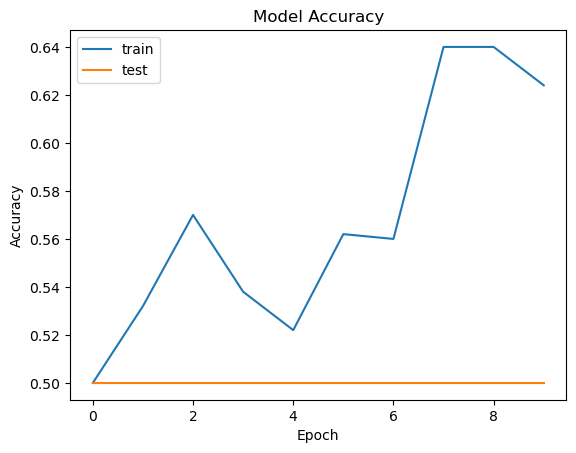

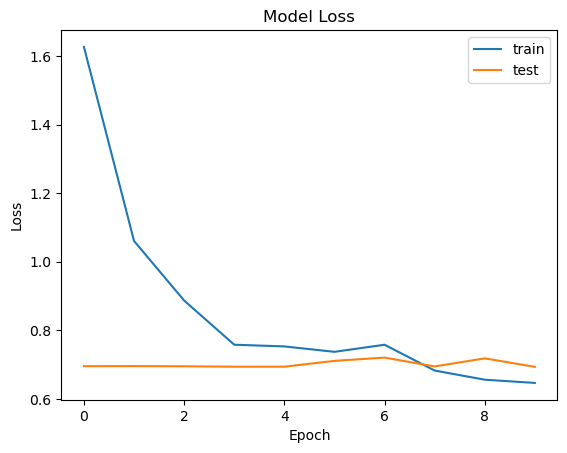

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend(['train','test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend(['train','test'])
plt.show()